In [139]:
import os
import pefile
import pandas as pd
import hashlib

In [140]:
def extract_imports(file_path):
    # Load the malware file with pefile
    pe = pefile.PE(file_path)

    # Extract the imported DLLs and functions
    imports = {'dlls': set(), 'functions': set()}
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        imports['dlls'].add(entry.dll.decode().lower())
        for imp in entry.imports:
            imports['functions'].add(imp.name.decode().lower())

    return imports

In [141]:
def extract_malware_characteristics(file_path):
    # Create a dictionary to store the characteristics
    characteristics = {}
    #print(os.path.basename(file_path))
    # Load the malware file with pefile
    pe = pefile.PE(file_path)

    # Extract the file name
    characteristics['file_name'] = os.path.basename(file_path)

    # Extract the size of the file
    characteristics['file_size'] = os.path.getsize(file_path)

    # Extract the entry point address
    characteristics['entry_point'] = pe.OPTIONAL_HEADER.AddressOfEntryPoint

    # Extract the number of sections
    characteristics['num_sections'] = pe.FILE_HEADER.NumberOfSections

    # Extract the timestamp
    characteristics['timestamp'] = pe.FILE_HEADER.TimeDateStamp

    # Extract the MD5 hash of the file
    with open(file_path, 'rb') as f:
        md5 = hashlib.md5(f.read()).hexdigest()
    characteristics['md5'] = md5
 # Extract the imported DLLs and functions
    imports = extract_imports(file_path)
    characteristics['dlls'] = len(';'.join(sorted(imports['dlls'])))
    characteristics['functions'] = len(';'.join(sorted(imports['functions'])))
    
    return characteristics


In [142]:
def extract_directory_characteristics(directory_path):
    # Create a list to store the characteristics
    characteristics_list = []

    # Loop through all the files in the directory
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        
        # Skip directories
        if os.path.isdir(file_path):
            continue
        if ".DS_Store" not in file_name:
        # Extract the characteristics of the file
            characteristics = extract_malware_characteristics(file_path)

        # Add the characteristics to the list
        characteristics_list.append(characteristics)
        
    # Convert the list to a pandas DataFrame
    df = pd.DataFrame(characteristics_list)

    return df


In [143]:
directory_path = '/home/rene/Documents/MALWR/'
df = extract_directory_characteristics(directory_path)
df.head()

,file_name,file_size,entry_point,num_sections,timestamp,md5,dlls,functions
0,EEE99EC8AA67B05407C01094184C33D2B5A44,5120,27632,3,1263576056,c6bc4ab329552467575de2fa323d5525,45,76
1,L11_1415EB8519D13328091CC5C76A624E3D,14336,2042528,3,1306744169,bc17ea78d743c26b7640c28b34827bbc,58,97
2,FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2,5632,28064,3,1242321160,60457bfba21f444030bcb55652265f76,57,98
3,8442AE37B91F279A9F06DE4C60B286A3,5120,27632,3,1263576056,b95f30fe09b54360e1c689105b6cad2d,45,76
4,F8437E44748D2C3FCF84019766F4E6DC,5632,28064,3,1242321160,a60efd35078178fe8a38bfa5ec19d447,57,98


In [144]:
from pandas_profiling import ProfileReport
df_f= ProfileReport(df)
df_f

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


In [145]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-pa

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

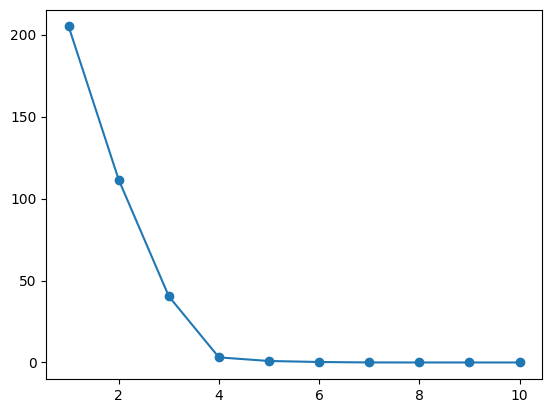

In [146]:
# Select the columns to be used for clustering
# Select the columns to be used for clustering
X = df[['file_size', 'entry_point', 'num_sections', 'dlls', 'functions']]

# Convert the DLLs and functions to one-hot encoded features
X_encoded = pd.get_dummies(X, columns=['dlls', 'functions'])

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with a range of cluster numbers
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel

El uso del método del codo para la agrupación de malware puede proporcionar un enfoque basado en datos para seleccionar la cantidad óptima de grupos en función de la forma del gráfico de cod, en este caso el codo es sutil debido a la cantidad de datos que se enuentran, y la grafica recomienda un numero de 3 clusters

/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


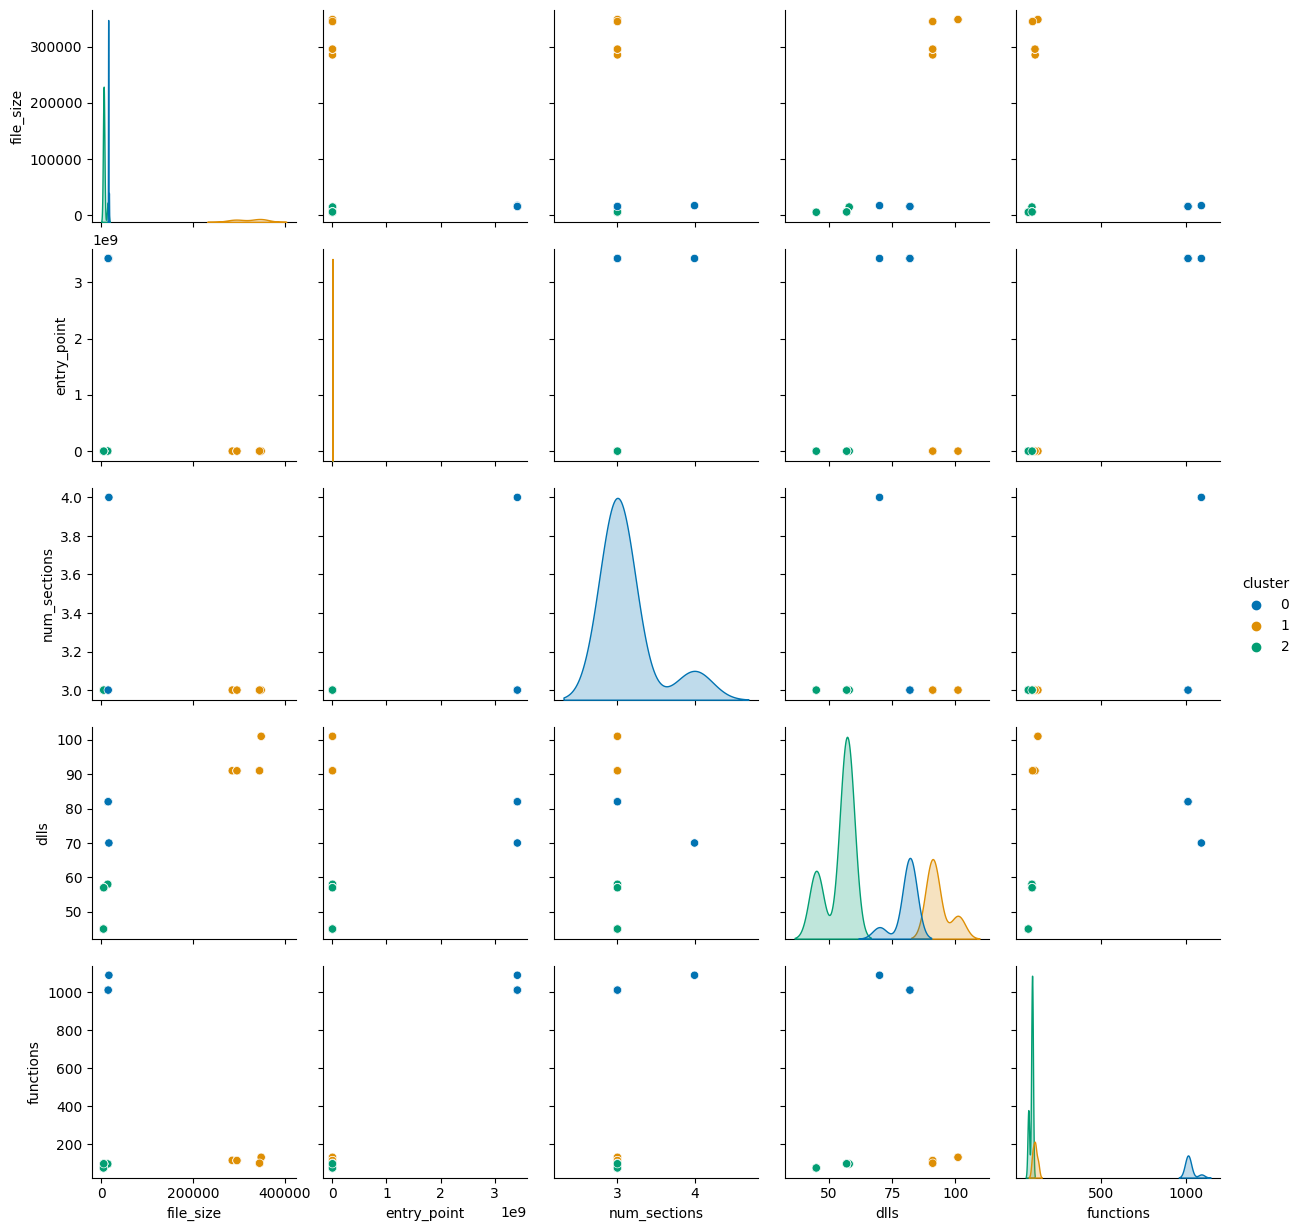

In [147]:
import seaborn as sns
# Select the columns to be used for clustering
X = df[['file_size', 'entry_point', 'num_sections', 'dlls', 'functions']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_
X_plot = df[['file_size', 'entry_point', 'num_sections', 'dlls', 'functions', 'cluster']]
sns.pairplot(X_plot, hue='cluster', palette='colorblind')
plt.show()
 

aqui se muestran los clusters obtenidos de la grafica de error del metodo de codo para cada feature analizada 

/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/rene/.local/lib/python3.10/site-pa

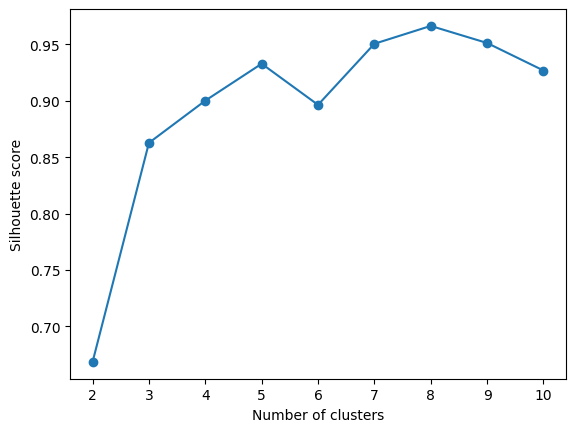

In [148]:
from sklearn.metrics import silhouette_score

# Select the columns to be used for clustering
X = df[['file_size', 'entry_point', 'num_sections', 'dlls', 'functions']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate the silhouette score for a range of cluster numbers
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores against the number of clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [149]:
# Fit K-means clustering algorithm to the data
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = cluster_labels

df

/home/rene/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,file_name,file_size,entry_point,num_sections,timestamp,md5,dlls,functions,cluster
0,EEE99EC8AA67B05407C01094184C33D2B5A44,5120,27632,3,1263576056,c6bc4ab329552467575de2fa323d5525,45,76,0
1,L11_1415EB8519D13328091CC5C76A624E3D,14336,2042528,3,1306744169,bc17ea78d743c26b7640c28b34827bbc,58,97,0
2,FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2,5632,28064,3,1242321160,60457bfba21f444030bcb55652265f76,57,98,0
3,8442AE37B91F279A9F06DE4C60B286A3,5120,27632,3,1263576056,b95f30fe09b54360e1c689105b6cad2d,45,76,0
4,F8437E44748D2C3FCF84019766F4E6DC,5632,28064,3,1242321160,a60efd35078178fe8a38bfa5ec19d447,57,98,0
5,NBV_8B75BCBFF174C25A0161F30758509A44,5632,28064,3,1242321160,d07399600be38dc86a9ee3e15ee3ba07,57,98,0
6,VC990_468FF2C12CFFC7E5B2FE0EE6BB3B239E,348160,775248,3,1294716122,c2e29392ab2269a917d50e408b4968cb,101,132,1
7,B98hX8E8622C393D7E832D39E620EAD5D3B49,285184,614704,3,1271734767,4f5d87ad12d7a5847699966556bf2894,91,116,1
8,JH78C0A33A1B472A8C16123FD696A5CE5EBB,5632,28064,3,1242321160,839583bde18d844c33397792f5165ba4,57,98,0
9,A316D5AECA269CA865077E7FFF356E7D,5632,28064,3,1242321160,b935e7000e4e2314b5fcfb102c274346,57,98,0


In [150]:
from sklearn.metrics import jaccard_score
import numpy as np
num_clusters=3
for i in range(num_clusters):
    for j in range(i+1, num_clusters):
        # Get the names of the malware in the ith and jth clusters
        cluster_i = df.loc[df['cluster'] == i, 'file_name'].values
        cluster_j = df.loc[df['cluster'] == j, 'file_name'].values
        
        # Calculate the Jaccard similarity between all pairs of malware in the ith and jth clusters
        for name_i in cluster_i:
            for name_j in cluster_j:
                malware_i = np.array(df.loc[df['file_name'] == name_i, 'functions'])
                malware_j = np.array(df.loc[df['file_name'] == name_j, 'functions'])
                jaccard_sim = jaccard_score(malware_i, malware_j, pos_label=None)
                print(f"Jaccard similarity between {name_i} and {name_j}: {jaccard_sim:.2f}")


ValueError: pos_label=None is not a valid label. It should be one of [76, 132]

Coclusiones

el coeficiente es mas alto para 8 clusters aproximadamente
si son aproximadamente similares ya que en el coeficiente de silueta no hay muchos cambios entre los coeficientes
se obtuvieron 3 clusters, o familias/